##1. Technical Requirements:

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Download intraday data for the past 5 days (5-min interval)
stock = 'AAPL'  # Replace with any major tech stock
data = yf.download(tickers=stock, interval='5m', period='5d')

[*********************100%***********************]  1 of 1 completed


In [22]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,,
2024-12-17 14:30:00+00:00,250.770004,250.770004,251.250000,249.789993,250.134995,2105605
2024-12-17 14:35:00+00:00,251.399994,251.399994,251.549896,250.589996,250.759995,621725
2024-12-17 14:40:00+00:00,252.779999,252.779999,252.860397,251.309998,251.399994,1196193
2024-12-17 14:45:00+00:00,252.570007,252.570007,252.809998,252.250000,252.750000,704175
2024-12-17 14:50:00+00:00,252.595001,252.595001,252.979996,252.509995,252.589996,585594


In [23]:
# Step 2: Calculate metrics
# 2.1 Rolling Volatility (1-hour window = 12 x 5-min intervals)
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Volatility'] = data['Log_Returns'].rolling(window=12).std()

In [24]:
# 2.2 Volume Weighted Average Price (VWAP)
data['VWAP'] = (data['Volume'] * (data['High'] + data['Low']) / 2).cumsum() / data['Volume'].cumsum()

In [25]:
# 2.3 Moving Averages (20 and 50 periods)
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

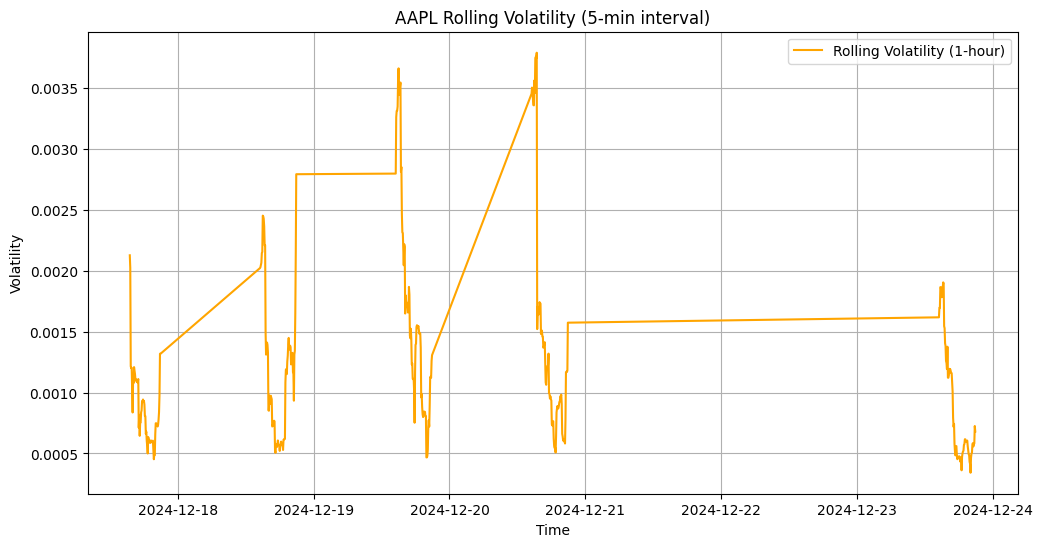

In [26]:
# Step 3: Visualize metrics
# 3.1 Rolling Volatility
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Volatility'], label='Rolling Volatility (1-hour)', color='orange')
plt.title(f'{stock} Rolling Volatility (5-min interval)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

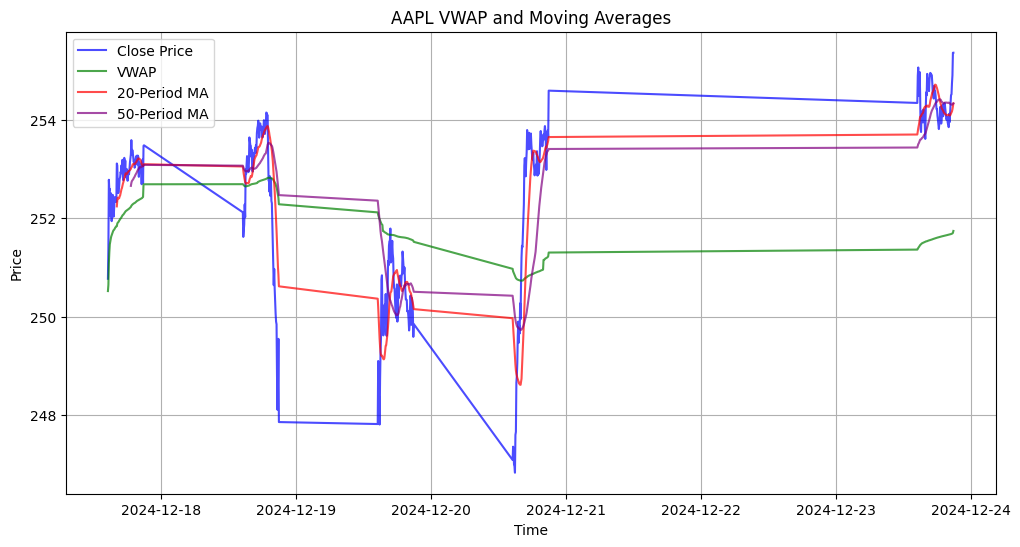

In [27]:
# 3.2 VWAP and Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(data.index, data['VWAP'], label='VWAP', alpha=0.7, color='green')
plt.plot(data.index, data['MA20'], label='20-Period MA', alpha=0.7, color='red')
plt.plot(data.index, data['MA50'], label='50-Period MA', alpha=0.7, color='purple')
plt.title(f'{stock} VWAP and Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Step 4: Identify unusual trading patterns
# Unusual: High rolling volatility or rapid MA20 and MA50 crossover
unusual = data[(data['Volatility'] > data['Volatility'].quantile(0.95)) |
               (data['MA20'] > data['MA50'])]
print("Unusual Trading Patterns:\n", unusual[['Close', 'Volatility', 'VWAP', 'MA20', 'MA50']])

Unusual Trading Patterns:
 Price                           Close Volatility        VWAP        MA20  \
Ticker                           AAPL                                      
Datetime                                                                   
2024-12-17 18:35:00+00:00  253.300003   0.000558  252.229267  253.002250   
2024-12-17 18:40:00+00:00  253.585007   0.000500  252.251071  253.034500   
2024-12-17 18:45:00+00:00  253.289993   0.000635  252.264413  253.039750   
2024-12-17 18:50:00+00:00  253.387299   0.000619  252.274705  253.067115   
2024-12-17 18:55:00+00:00  253.335007   0.000611  252.283345  253.095365   
...                               ...        ...         ...         ...   
2024-12-23 18:05:00+00:00  254.080002   0.000477  251.606146  254.604941   
2024-12-23 18:10:00+00:00  254.000000   0.000466  251.608244  254.570941   
2024-12-23 18:15:00+00:00  253.899994   0.000435  251.610572  254.536941   
2024-12-23 18:20:00+00:00  253.809906   0.000432  251.613151 

## 2. Analysis Tasks:

In [29]:
# Step 1: Data Cleaning

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Price        Ticker
Adj Close    AAPL       0
Close        AAPL       0
High         AAPL       0
Low          AAPL       0
Open         AAPL       0
Volume       AAPL       0
Log_Returns             1
Volatility             12
VWAP                    0
MA20                   19
MA50                   49
dtype: int64


In [30]:
# Handling missing values by filling with the previous valid value (forward fill)
data.fillna(method='bfill', inplace=True)

<ipython-input-30-93677ec30bfc>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [31]:
# Check for any remaining missing values
print("\nMissing Values After Fill:\n", data.isnull().sum())


Missing Values After Fill:
 Price        Ticker
Adj Close    AAPL      0
Close        AAPL      0
High         AAPL      0
Low          AAPL      0
Open         AAPL      0
Volume       AAPL      0
Log_Returns            0
Volatility             0
VWAP                   0
MA20                   0
MA50                   0
dtype: int64


In [32]:
# Step 2: Handling Outliers
# We will use the IQR method to detect outliers in 'Close' prices

Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the 'Close' price
outliers = data[(data['Close'] < lower_bound) | (data['Close'] > upper_bound)]

# Remove outliers
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]

print(f"\nRemoved {len(outliers)} outliers.")


Removed 390 outliers.


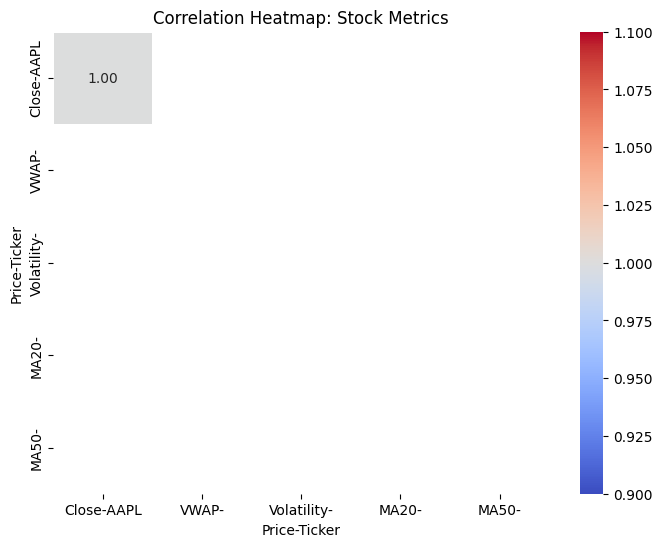

In [33]:
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = data[['Close', 'VWAP', 'Volatility', 'MA20', 'MA50']].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Stock Metrics')
plt.show()

In [34]:
# Step 3: Statistical Measures

# Standard Deviation
std_dev = data['Close'].std()
print(f"Standard Deviation of Close Prices: {std_dev}")

# Skewness
skewness = data['Close'].skew()
print(f"Skewness of Close Prices: {skewness}")

Standard Deviation of Close Prices: Ticker
AAPL    1.774981
dtype: float64
Skewness of Close Prices: Ticker
AAPL   -0.894665
dtype: float64


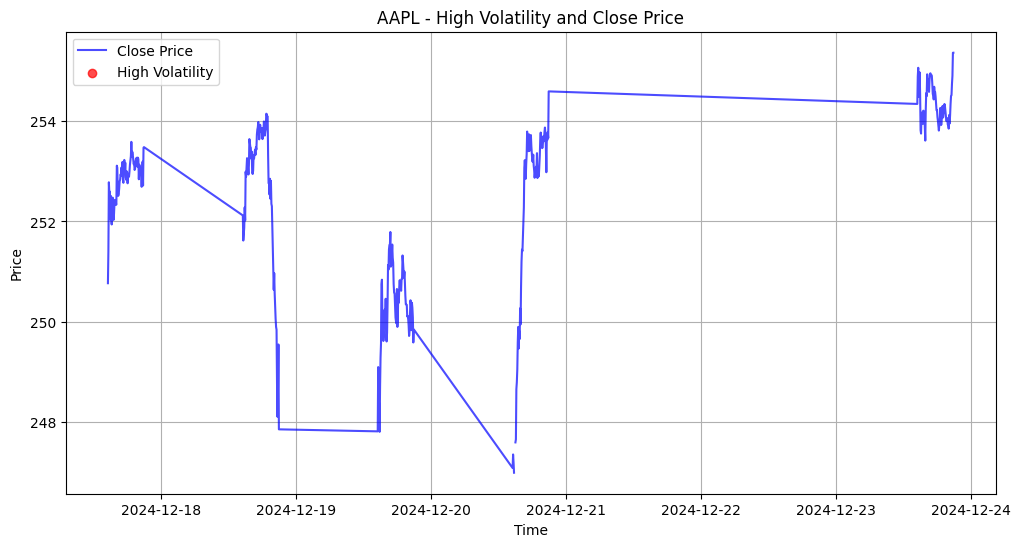

High Volatility Periods:
 Empty DataFrame
Columns: [(Close, AAPL), (Volatility, )]
Index: []


In [35]:
# Identify periods of high volatility (Top 5% by volatility)
high_volatility = data[data['Volatility'] > data['Volatility'].quantile(0.95)]

# Investigate how high volatility correlates with stock price behavior
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.7)
plt.scatter(high_volatility.index, high_volatility['Close'], color='red', label='High Volatility', alpha=0.7)
plt.title(f'{stock} - High Volatility and Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Print the high volatility periods for deeper analysis
print("High Volatility Periods:\n", high_volatility[['Close', 'Volatility']])
